#### Payment organization **[Elo](http://)**, which is operated widely in Brazil offer discounts for card-holders. Elo wants to know that is really these discounts helpful to keep the card-holders happy.

#### Based on target-score we are going to predict whether discounts helpful or not.

#### I will use train & historical_transactions for training and testing purpose.
 
#### As Dependent variable is continuous so I will use regression algorithms starting from basic Linear-Regression model to Gradient boosting models and RMSE as evaluation metric


#### Importing required Libraries

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
import xgboost as xgb

#### Importing data files

In [2]:
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")
hist_transactions=pd.read_csv("../input/historical_transactions.csv")

### Data preprocessing

In [3]:
# looking for dimensions of data
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [5]:
hist_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
train.shape, test.shape, hist_transactions.shape

((201917, 6), (123623, 5), (29112361, 14))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


In [9]:
hist_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [10]:
train.describe(include='all')

,first_active_month,card_id,feature_1,feature_2,feature_3,target
count,201917,201917,201917.000000,201917.000000,201917.000000,201917.000000
unique,75,201917,NaN,NaN,NaN,NaN
top,2017-09,C_ID_32d687bbcf,NaN,NaN,NaN,NaN
freq,13878,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.105311,1.745410,0.565569,-0.393636
std,NaN,NaN,1.186160,0.751362,0.495683,3.850500
min,NaN,NaN,1.000000,1.000000,0.000000,-33.219281
25%,NaN,NaN,2.000000,1.000000,0.000000,-0.883110
50%,NaN,NaN,3.000000,2.000000,1.000000,-0.023437
75%,NaN,NaN,4.000000,2.000000,1.000000,0.765453


In [11]:
hist_transactions.describe(include='all')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,29112361,29112361,2.911236e+07,29112361,2.911236e+07,28934202,2.911236e+07,28973880,2.911236e+07,2.911236e+07,29112361,2.645950e+07,2.911236e+07,2.911236e+07
unique,2,325540,NaN,2,NaN,3,NaN,326311,NaN,NaN,16395300,NaN,NaN,NaN
top,Y,C_ID_3d3dfdc692,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-24 00:00:00,NaN,NaN,NaN
freq,26595452,5582,NaN,27028332,NaN,15411747,NaN,1115097,NaN,NaN,26184,NaN,NaN,NaN
mean,NaN,NaN,1.293256e+02,NaN,6.484954e-01,NaN,4.810130e+02,NaN,-4.487294e+00,3.640090e-02,NaN,2.194578e+00,1.056679e+01,2.684839e+01
std,NaN,NaN,1.042563e+02,NaN,2.795577e+00,NaN,2.493757e+02,NaN,3.588800e+00,1.123522e+03,NaN,1.531896e+00,6.366927e+00,9.692793e+00
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.300000e+01,-7.469078e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,5.300000e+01,NaN,0.000000e+00,NaN,3.070000e+02,NaN,-7.000000e+00,-7.203559e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,9.000000e+01,NaN,0.000000e+00,NaN,4.540000e+02,NaN,-4.000000e+00,-6.883495e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,7.050000e+02,NaN,-2.000000e+00,-6.032543e-01,NaN,3.000000e+00,1.600000e+01,3.400000e+01


Text(0.5, 1.0, 'missing values count')

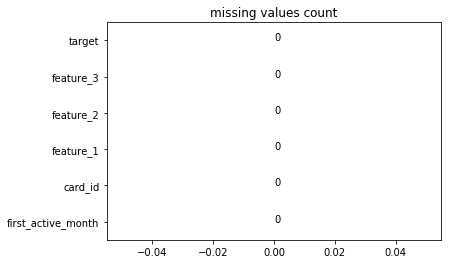

In [12]:
#Checking for NA values in train 
train.isna().sum().plot(kind='barh')
for i, v in enumerate(train.isna().sum()):
    plt.text( v,i, str(v))
plt.title('missing values count')

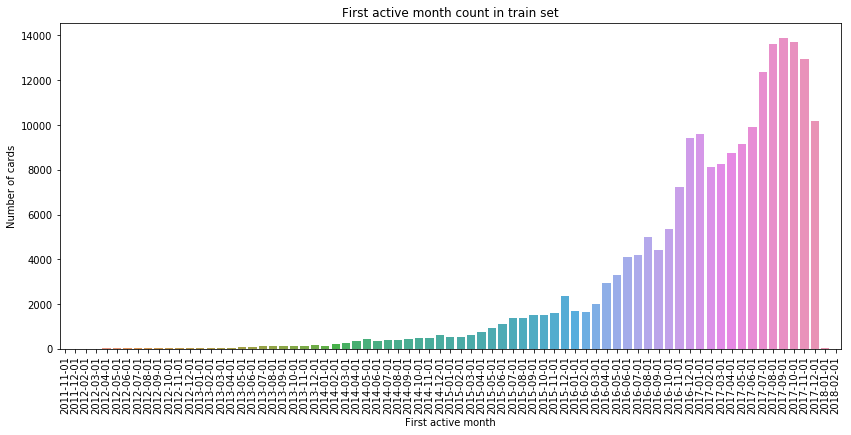

In [13]:
# Distribution of cards used first-time 

train['first_active_month']=pd.to_datetime(train['first_active_month'])
count = train['first_active_month'].dt.date.value_counts()
count= count.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(count.index, count.values)
plt.xticks(rotation='vertical')
plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title("First active month count in train set")
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


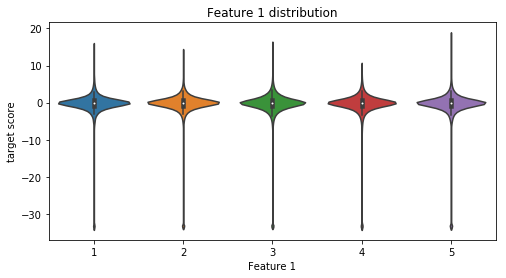

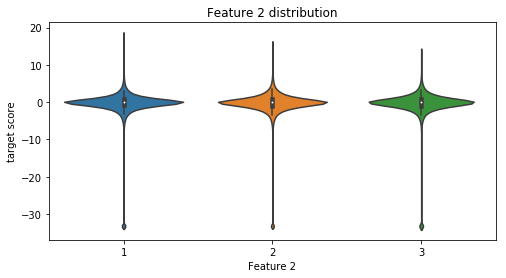

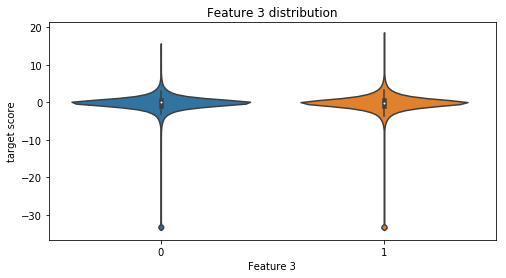

In [14]:
# Checking for the distributions of features using violin plot

# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y='target', data=train)
plt.xlabel('Feature 1')
plt.ylabel('target score')
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y='target', data=train)
plt.xlabel('Feature 2')
plt.ylabel('target score')
plt.title("Feature 2 distribution")
plt.show()
 
# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y='target', data=train)
plt.xlabel('Feature 3')
plt.ylabel('target score')
plt.title("Feature 3 distribution")
plt.show()

#### Hist_transactions dataset

month_lag

In [15]:
Avg_month_lag= np.round(hist_transactions.groupby('card_id')['month_lag'].agg('mean').reset_index())
train= pd.merge(train, Avg_month_lag, on="card_id")

Card-id

In [16]:
num_trans = hist_transactions.card_id.value_counts().reset_index()
num_trans.columns = ["card_id", "hist_transactions/card"]
train= pd.merge(train, num_trans, on="card_id")

Text(0.5, 1.0, 'Number of hist_transactions/card  vs target score')

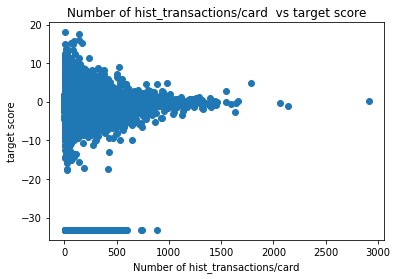

In [17]:
plt.scatter('hist_transactions/card', 'target', data=train)
plt.xlabel('Number of hist_transactions/card')
plt.ylabel('target score')
plt.title('Number of hist_transactions/card  vs target score')

Purchase_amount

In [18]:
pur_amt = hist_transactions.groupby("card_id")
pur_amt = pur_amt["purchase_amount"].agg('mean').reset_index()
pur_amt.columns = ["card_id", "purchase_amt"]
train= pd.merge(train, pur_amt, on="card_id")

Text(0.5, 1.0, 'Number of hist_transactions/card  Vs target score')

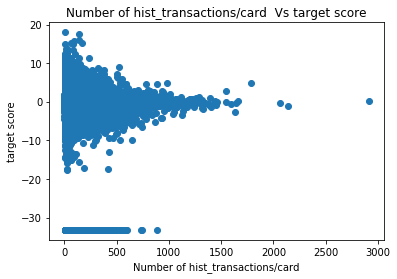

In [19]:
plt.scatter('hist_transactions/card', 'target', data=train)
plt.xlabel('Number of hist_transactions/card')
plt.ylabel('target score')
plt.title('Number of hist_transactions/card  Vs target score')

Installments

In [20]:
installments_percard = np.round(hist_transactions.groupby('card_id')['installments'].agg('mean').reset_index())
train= pd.merge(train, installments_percard, on="card_id")

Text(0.5, 1.0, 'no.of installments Vs target scre')

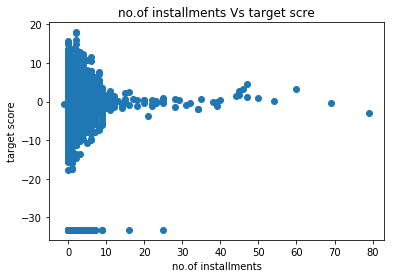

In [21]:
plt.scatter('installments', 'target', data=train)
plt.xlabel('no.of installments')
plt.ylabel('target score')
plt.title('no.of installments Vs target scre')

first_active_month

In [22]:
train['first_active_month']=pd.to_datetime(train['first_active_month'])

train['first_active_year']=train['first_active_month'].dt.year
train['first_active_month']=train['first_active_month'].dt.month


Text(0.5, 1.0, 'target-score distribution')

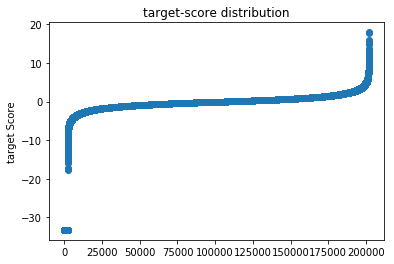

In [23]:
plt.scatter(range(train.shape[0]), np.sort(train.target))
plt.ylabel('target Score')
plt.title('target-score distribution')

Checking for correlatioin between variables

Text(0.5, 1.0, 'Correlation map')

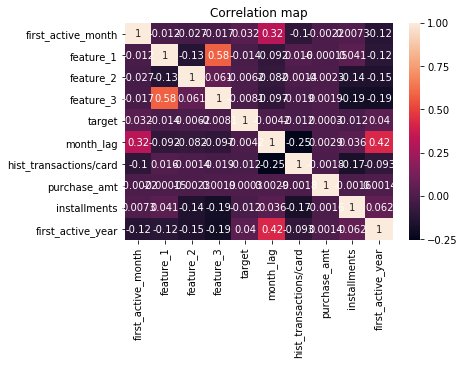

In [24]:
sns.heatmap(train.corr(), annot=True)
plt.title('Correlation map')

Splitting dataset into train and test sets

In [25]:
train_x=train.drop(['target',  'card_id'], axis=1)
train_y=train['target']

In [26]:
x_train, x_test, y_train, y_test=train_test_split(train_x, train_y, test_size=0.33)

In [27]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((135284, 9), (66633, 9), (135284,), (66633,))

Linear regression model

In [28]:
model=LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
predict=model.predict(x_test)
predict_train=model.predict(x_train)

In [30]:
print('RMSE test:', np.sqrt(np.mean((predict - y_test)**2)))
print('RMSE train:', np.sqrt(np.mean((predict_train - y_train)**2)))

RMSE test: 3.8024902817073425
RMSE train: 3.858696318172408


Randomforest Regresssor

In [31]:
model_rf=RandomForestRegressor()
model_rf.fit(x_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
predict_rf=model_rf.predict(x_test)
predict_rf_train=model_rf.predict(x_train)

In [33]:
print('Test RMSE RF:', np.sqrt(np.mean((predict_rf - y_test)**2)))
print('Train RMSE RF:', np.sqrt(np.mean((predict_rf_train - y_train)**2)))

Test RMSE RF: 4.1604471384389745
Train RMSE RF: 1.785149556496978


parameter_tuning in Randomforest Regresssor

In [34]:
Random_Search_Params ={
    'max_features':[1,2,3,4,5,6,7,8,9,10],
    "max_depth": list(range(1,train.shape[1])),
    'n_estimators' : [1, 2, 4, 8, 50, 100,150, 200, 250, 300],
    "min_samples_leaf": [5,10,15,20,25],
    'random_state' : [42] 
    }


random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions= Random_Search_Params, 
    cv=3,
    refit=True,
    verbose=True)

In [35]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [1, 2, 4, 8, 50, 100, 150, 200, 250, 300], 'min_samples_leaf': [5, 10, 15, 20, 25], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=True)

In [36]:
random_search.best_params_

{'random_state': 42,
 'n_estimators': 300,
 'min_samples_leaf': 5,
 'max_features': 6,
 'max_depth': 6}

In [37]:


model_rf_tune=RandomForestRegressor( random_state=42, 
                                     n_estimators=250, min_samples_leaf=15,
                                     max_features=6, max_depth=7 )

In [38]:
model_rf_tune.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=15,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [39]:
predict_rf_tune=model_rf_tune.predict(x_test)

predict_rf_tune_train=model_rf_tune.predict(x_train)

In [40]:
print('Test RMSE RF_tune_:', np.sqrt(np.mean((predict_rf_tune - y_test)**2)))
print('Train RMSE RF_tune:', np.sqrt(np.mean((predict_rf_tune_train - y_train)**2)))

Test RMSE RF_tune_: 3.7827581600180626
Train RMSE RF_tune: 3.813227066212547


lgb model

In [41]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbrt",
         "metric": 'rmse'}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000,  n_jobs = -1)
lgb_model.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.80084	valid_1's rmse: 3.78187
Early stopping, best iteration is:
[478]	training's rmse: 3.81456	valid_1's rmse: 3.78084


LGBMRegressor(boosting='gbrt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
       max_depth=5, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=30,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

XGBoost model

In [42]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': 0.8,
              
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

model_xgb = xgb.XGBRegressor() 
model_xgb.fit(x_train, y_train)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [43]:
trainPredict_xgb = model_xgb.predict(x_train)
testPredict_xgb = model_xgb.predict(x_test)

print("xgb test RMSE:", np.sqrt(mean_squared_error(y_test, testPredict_xgb)))
print("xgb train RMSE:", np.sqrt( mean_squared_error(y_train, trainPredict_xgb)))

xgb test RMSE: 3.7845331041105577
xgb train RMSE: 3.8275247558933843
